In [1]:
#meta 11/2/2020 Kaggle MOA Data Prep
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/lish-moa/overview
#input: 5 kaggle files (added drugs.csv in middle of competition)
#output: none

#history
#11/10/2020 MY EDA MINIMAL
#      limited EDA. confirmed control samples have no MOAs
#      optional changes: categorical features 
#      Data prep steps are so minimal, no reason to do it here; move it to 1-model notebook.
#next: Modeling with fast.ai


#some references:
#tutorial https://www.kaggle.com/sinamhd9/mechanisms-of-action-moa-tutorial

# Mechanisms of Action (MoA) Prediction
Can you improve the algorithm that classifies drugs based on their biological activity?

Data description:  
In this competition, you will be predicting multiple targets of the Mechanism of Action (MoA) response(s) of different samples (sig_id), given various inputs such as gene expression data and cell viability data.

Two notes:

1.  the training data has an additional (optional) set of MoA labels that are not included in the test data and not used for scoring.
2.  the re-run dataset has approximately 4x the number of examples seen in the Public test.

In [2]:
import pandas as pd
import numpy as np
import os

from joblib import dump, load #persistence

## 0. Load data

0. Train drug master data 23814 x 2 (sig_id, drug_id)  
1. Train features 23814 x 876 (sig_id)  
2. Train targets 23814 x 403 (non-scored)  
3. Train targets 23814 x 207 (scored)  
4. Test features 3982 x 876


In [3]:
#$note: local path in my git repo, not in Kaggle competition
data_path = "myData/kaggle/lish-moa/"

In [4]:
df_drug = pd.read_csv(data_path + 'train_drug.csv')
display(df_drug.head(3))
print('train drug data size', df_drug.shape)

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c


train drug data size (23814, 2)


In [5]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sig_id   23814 non-null  object
 1   drug_id  23814 non-null  object
dtypes: object(2)
memory usage: 372.2+ KB


In [6]:
df_drug.describe()

,sig_id,drug_id
count,23814,23814
unique,23814,3289
top,id_2ad7cd54c,cacb2b860
freq,1,1866


In [7]:
df_train = pd.read_csv(data_path + 'train_features.csv')
display(df_train.head(3))
print('train data size', df_train.shape)

df_target_ns = pd.read_csv(data_path + 'train_targets_nonscored.csv')
display(df_target_ns.head(3))
print('train target nonscored size', df_target_ns.shape)

df_target_s = pd.read_csv(data_path + '/train_targets_scored.csv')
display(df_target_s.head(3))
print('train target scored size', df_target_s.shape)

df_test = pd.read_csv(data_path + 'test_features.csv')
display(df_test.head(3))
print('test data size', df_test.shape)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


train data size (23814, 876)


,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train target nonscored size (23814, 403)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train target scored size (23814, 207)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


test data size (3982, 876)


5. Sample submission 3982 x 207
For each sig_id predict if belongs to each of 207 categories

In [8]:
df_sample = pd.read_csv(data_path + 'sample_submission.csv')
display(df_sample.head(3))
print('sample submission size', df_sample.shape)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


sample submission size (3982, 207)


Prep data

In [9]:
df_merged = df_train.merge(df_drug)
print(df_merged.shape)
print(df_merged.columns)
df_merged.head()

(23814, 877)
Index(['sig_id', 'cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1', 'g-2', 'g-3',
       'g-4', 'g-5',
       ...
       'c-91', 'c-92', 'c-93', 'c-94', 'c-95', 'c-96', 'c-97', 'c-98', 'c-99',
       'drug_id'],
      dtype='object', length=877)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,drug_id
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,b68db1d53
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,df89a8e5a
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,18bb41b2c
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,8c7f86626
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,7cbed3131


In [10]:
df_merged.drug_id.value_counts()

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
             ... 
a90e40334       1
b046f598b       1
153840764       1
f49a73cd5       1
c5ffd58ca       1
Name: drug_id, Length: 3289, dtype: int64

In [11]:
#so many cacb2b860
df_merged[df_merged['drug_id']=='cacb2b860']
#looks like all ctl_vehicles

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,drug_id
25,id_0054388ec,ctl_vehicle,48,D1,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,cacb2b860
38,id_0079af0fb,ctl_vehicle,24,D1,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,cacb2b860
40,id_007bfbb91,ctl_vehicle,24,D2,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,cacb2b860
47,id_008a986b7,ctl_vehicle,48,D2,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,cacb2b860
63,id_009d8340f,ctl_vehicle,24,D2,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,cacb2b860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,ctl_vehicle,24,D1,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,cacb2b860
23747,id_ff469c482,ctl_vehicle,72,D1,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,cacb2b860
23768,id_ff89331ca,ctl_vehicle,72,D2,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,cacb2b860
23793,id_ffd26f361,ctl_vehicle,48,D2,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,cacb2b860


###  0.1 EDA

#### 0.1.1 Train set features

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [13]:
#check missing values - none
#df_train.isnull().sum().sum() #if none returns 0
df_train.isnull().sum().any() # if none returns False, True if there are missing values

False

##### Generate descriptive statistics.

Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

Analyzes both numeric and object series

In [14]:
#all numeric columns with None
df_train.describe() 

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


48    8250
72    7792
24    7772
Name: cp_time, dtype: int64


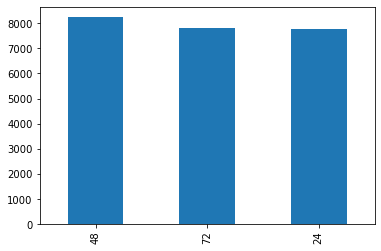

In [15]:
#explore type int
print(df_train['cp_time'].value_counts())
df_train['cp_time'].value_counts().plot(kind='bar')

In [16]:
#all object columns
df_train.describe(include='object') 
#explore categorical
#df_train.describe(include='category')

,sig_id,cp_type,cp_dose
count,23814,23814,23814
unique,23814,2,2
top,id_2ad7cd54c,trt_cp,D1
freq,1,21948,12147


trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64


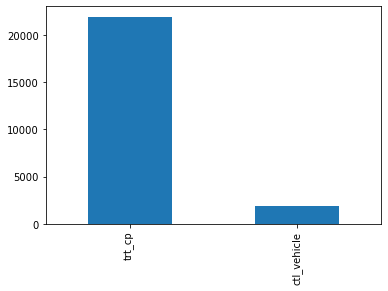

In [17]:
print(df_train['cp_type'].value_counts())
df_train['cp_type'].value_counts().plot(kind='bar');

D1    12147
D2    11667
Name: cp_dose, dtype: int64


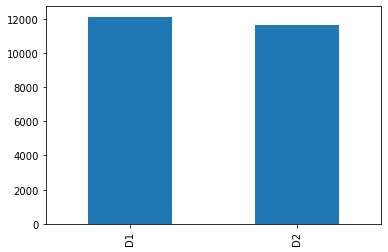

In [18]:
print(df_train['cp_dose'].value_counts())
df_train['cp_dose'].value_counts().plot(kind='bar');

#### 0.1.2 Train set targets
- Scored

In [19]:
df_target_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 207 entries, sig_id to wnt_inhibitor
dtypes: int64(206), object(1)
memory usage: 37.6+ MB


In [20]:
df_target_s.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Check Missing Targets
Discussion that records with cp_type = 'ctl_vehicle' have all targets 0s

In [21]:
#find records with cp_type = 'ctl_vehicle' in features train set
idx_ctl_vehicles = df_train[df_train['cp_type']=='ctl_vehicle'].index
idx_ctl_vehicles

Int64Index([   25,    38,    40,    47,    63,    81,    96,   117,   133,
              148,
            ...
            23625, 23656, 23658, 23683, 23722, 23729, 23747, 23768, 23793,
            23811],
           dtype='int64', length=1866)

In [22]:
#confirm that all targets are 0
display(df_target_s.iloc[idx_ctl_vehicles].head())
#returns 0 if all are zeros
print("Sum all targets where cp_type = 'ctl_vehicle':", df_target_s.iloc[idx_ctl_vehicles, 1:].sum().sum())

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
25,id_0054388ec,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,id_0079af0fb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,id_007bfbb91,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,id_008a986b7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63,id_009d8340f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Sum all targets where cp_type = 'ctl_vehicle': 0


In [23]:
#confirm the opposite that records with cp_type != 'ctl_vehicle' have all targets non-zeros
target_s_zeros = df_target_s.index.isin(idx_ctl_vehicles) #class numpy.ndarray of booleans
#sample vector
#print(target_s_zeros[:5])


In [24]:
df_target_s[target_s_zeros].describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,...,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0,1866.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_target_s[~target_s_zeros].describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,...,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000
mean,0.000775,0.000820,0.001093,0.008657,0.013714,0.003326,0.002460,0.004374,0.000547,0.012302,...,0.000273,0.001139,0.002187,0.014398,0.003326,0.000273,0.007746,0.001185,0.001777,0.001367
std,0.027821,0.028627,0.033051,0.092641,0.116305,0.057577,0.049542,0.065993,0.023377,0.110232,...,0.016532,0.033731,0.046715,0.119126,0.057577,0.016532,0.087669,0.034399,0.042117,0.036947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# False if all are non-zeros , True if there are missing targets meaning there're some zeros
print("Zero targets where cp_type != 'ctl_vehicle':", (df_target_s[~target_s_zeros][df_target_s.columns[1:]].sum() == 0).any())

Zero targets where cp_type != 'ctl_vehicle': False


In [27]:
mystop

NameError: name 'mystop' is not defined

## 1. [optional] Data Prep

Data types and changes. Just one change really for `cp_time` ordinal categories, ok to do it in 1-Model notebook.

In [ ]:
#print(df_train.iloc[:,:6].head())
df_train.dtypes

In [ ]:
#copy original dataset before changing data types
df_train_original = df_train.copy()
df_test_original = df_test.copy()

Categorical features

In [ ]:
#ordinal
cp_time = np.sort(df_train['cp_time'].unique()) #numpy.ndarray [24,48,72]

df_train['cp_time'] = df_train['cp_time'].astype('category')
df_train['cp_time'].cat.set_categories(cp_time, ordered=True, inplace=True)
print("ordinal: ", df_train['cp_time'].unique())

df_test['cp_time'] = df_test['cp_time'].astype('category')
df_test['cp_time'].cat.set_categories(cp_time, ordered=True, inplace=True)
print("ordinal: ", df_test['cp_time'].unique())

##non-ordinal - ok to leave as is, will be taken care by fastai procs [Categorize]
#df_train_tidy['cp_type'] = df_train_tidy['cp_type'].astype('category')
#df_train_tidy['cp_dose'] = df_train_tidy['cp_dose'].astype('category')


In [ ]:
#ensure 3 cats
#df_train_tidy.dtypes

In [ ]:
#save
#dump(df_train_tidy, "myData/kaggle_moa/df_train_tidy.pkl")